In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages


import jax.numpy as jnp
import jax
import time
import tqdm


def get_all_filenames(file_type, model_output_path="model_output/", finals_only=False, intermediates_only=True, ignore_chimeric=True) -> list:
    """
      fuzzy list of all filenames of a specific type in a directory:
    """
    if file_type=="seed":
        ext="csv"
    else: 
        ext="parquet"
    l = []
    for f in Path(str(model_output_path)).rglob(f'*.{ext}'):
        f = str(f)
        if file_type in f:
            if (finals_only and "final" in f) or (intermediates_only and "intermediate" in f) or (not finals_only and not intermediates_only):
                if not (ignore_chimeric and "chimeric" in f):
                    l.append(str(f))
    return l

class RunInfo():
    """ Store the information to reproduce and buid a run"""
    def __init__(self, run_id, config_path=None, folder_path=None):
        self.run_id = run_id
        self.config_path = config_path
        self.folder_path = folder_path
        self.gempyor_simulator=None

    def get_all_filenames(self, file_type, finals_only=False, intermediates_only=True, ignore_chimeric=True) -> list:
        return get_all_filenames(file_type, model_output_path=self.folder_path, finals_only=finals_only, intermediates_only=intermediates_only, ignore_chimeric=ignore_chimeric)


mask10 = '00000001'   # So we just do

In [2]:
max_files = -1  # files to load for median an Qx
max_files_deep = 10 # number of files for deep inspection, or singled out in plots
data_dir = "COVID19_USA/"
pull_dir = "pruned/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

### Setup from slack message

In [3]:
slack_message = """
Launching USA-20230523T133717_inference_med on slurm...
 >> Job array: 300 slot(s) X 1 block(s) of 100 simulation(s) each.
 >> Resuming from run id is SMH_R17_noBoo_lowIE_phase2_blk2 located in s3://idd-inference-runs/USA-20230518T145612_pruned
 >> Final output will be: /scratch4/struelo1/flepimop-runs/USA-20230523T133717/model_output/
 >> Final output will be uploaded to s3://idd-inference-runs/USA-20230523T133717/model_output/
 >> Run id is SMH_R17_noBoo_lowIE_phase2_blk2
 >> config is config_SMH_R17_noBoo_lowIE_phase2_blk2.yml
 >> FLEPIMOP branch is seeding_fix with hash 2659f18b25683a606528890560e442db1e55c2fd
 >> DATA branch is R17 with hash 400b41448c79bf7f08e1a95c1e40f2f22d6de676
 ------------------------- END -------------------------
Switched to a new branch 'run_USA-20230523T133717'
"""

# Extracting relevant information using regular expressions
run_name = run_id = re.search(r"Launching (.+) on ", slack_message).group(1)
run_id = re.search(r"Run id is (.+)", slack_message).group(1)
config_name = re.search(r"config is (.+)", slack_message).group(1)
flepimop_branch = re.search(r"FLEPIMOP branch is (.+) with hash", slack_message).group(1)
data_branch = re.search(r"DATA branch is (.+) with hash", slack_message).group(1)
resuming_run_id = re.search(r"Resuming from run id is (.+) located in", slack_message).group(1)
resuming_s3_bucket = re.search(r"Resuming from run id is .+ located in (s3://[^ \n]+)", slack_message).group(1) + "/model_output/"
number_of_slots = re.search(r"Job array: (\d+) slot", slack_message).group(1)
final_output_s3_bucket = re.search(r"Final output will be uploaded to (s3://[^ \n]+)", slack_message).group(1)

print("Run Name:", run_name)
print("Run ID:", run_id)
print("Config:", config_name)
print("FLEPIMOP Branch:", flepimop_branch)
print("Data Branch:", data_branch)
print("Resuming Run ID:", resuming_run_id)
print("Resuming S3 Bucket:", resuming_s3_bucket)
print("Number of Slots:", number_of_slots)
print("Final Output S3 Bucket:", final_output_s3_bucket)

Run Name: USA-20230523T133717_inference_med
Run ID: SMH_R17_noBoo_lowIE_phase2_blk2
Config: config_SMH_R17_noBoo_lowIE_phase2_blk2.yml
FLEPIMOP Branch: seeding_fix
Data Branch: R17
Resuming Run ID: SMH_R17_noBoo_lowIE_phase2_blk2
Resuming S3 Bucket: s3://idd-inference-runs/USA-20230518T145612_pruned/model_output/
Number of Slots: 300
Final Output S3 Bucket: s3://idd-inference-runs/USA-20230523T133717/model_output/


In [4]:
if False:
    # this is annoying and I should be able to run from here. Now the s3 pull needs to be in the directoy
    if shutil.os.path.exists("model_output"):
        print("removing existing model_output")
        shutil.rmtree("model_output")


    # Copy the source folder to the destination
    shutil.copytree(f"{pull_dir}{run_name}/", "model_output")

In [7]:

fs_results_path = "model_output" 

run_info = RunInfo(run_id = run_id, 
                   config_path= f"{data_dir}/{config_name}",
                   folder_path = f"{fs_results_path}")

run_info.gempyor_simulator = gempyor.GempyorSimulator(
    config_path=run_info.config_path,
    run_id=run_info.run_id,
    #prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.",
    first_sim_index=1,
    npi_scenario="inference",  # NPIs scenario to use
    outcome_scenario="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    spatial_path_prefix=f"{data_dir}/",  # prefix where to find the folder indicated in spatial_setup$
)

run_info.gempyor_simulator.update_prefix(new_prefix=f"USA/inference/med/{run_id}/global/final/")
subpop_names = run_info.gempyor_simulator.s.subpop_struct.subpop_names

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: SMH_R17_noBoo_lowIE_phase2_blk2,
  gempyor >> prefix: test_prefix;


In [ ]:
run_info.gempyor_simulator.one_simulation(sim_id2write=500,
        load_ID=True,
        sim_id2load=40)

In [ ]:
run_info.gempyor_simulator.plot_transition_graph(output_file="full_graph")
run_info.gempyor_simulator.plot_transition_graph(
    output_file="readable_graph",
    source_filters=[["age0to17"],["unvaccinated"]]
)

In [ ]:
run_info.gempyor_simulator.plot_transition_graph(
    output_file="readable_graph2",
    source_filters=[["age0to17"],["2dose"]]
)

In [ ]:
fnct_args = gempyor.seir.build_step_source_arg(run_info.gempyor_simulator.s,
    run_info.gempyor_simulator.lastsimparsed_parameters,
    run_info.gempyor_simulator.transition_array,
    run_info.gempyor_simulator.proportion_array,
    run_info.gempyor_simulator.proportion_info,
    run_info.gempyor_simulator.lastsiminitial_conditions,
    run_info.gempyor_simulator.lastsimseeding_data,
    run_info.gempyor_simulator.lastsimseeding_amounts,)

In [ ]:
(
    transition_source_col,
    transition_destination_col,
    transition_rate_col,
    transition_proportion_start_col,
    transition_proportion_stop_col,
) = np.arange(5)

proportion_sum_starts_col = 0
proportion_sum_stops_col = 1
proportion_exponent_col = 2

float_tolerance = 1e-9

In [ ]:
# convert argument to jax
import numba as nb
fnct_args_jax = {}
for key, value in fnct_args.items():
    if isinstance(value, np.ndarray) and not "seeding" in key:
        fnct_args_jax[key] = value#jnp.array(value)
        print(f"{key}: {type(value)} >> {type(fnct_args_jax[key])}")
    elif not isinstance(value, nb.typed.typeddict.Dict):
        fnct_args_jax[key] = value
        print(f"{key}: {type(value)} >> {type(fnct_args_jax[key])}")
    else:
        for k,v in value.items():
            fnct_args_jax["seed_"+k] = np.array(v) # seeding stays numpy
            print(f" --  {key},{k} {type(v)} >> {type(fnct_args_jax['seed_'+k])}")

ncompartments: <class 'int'> >> <class 'int'>
nspatial_nodes: <class 'int'> >> <class 'int'>
ndays: <class 'int'> >> <class 'int'>
parameters: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
dt: <class 'float'> >> <class 'float'>
transitions: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
proportion_info: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
transition_sum_compartments: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
initial_conditions: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
 --  seeding_data,seeding_sources <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
 --  seeding_data,seeding_destinations <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
 --  seeding_data,seeding_places <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
 --  seeding_data,day_start_idx <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
seeding_amounts: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
mobility_data: <class 'numpy.ndarray'> >> <class 'numpy.ndarray'>
mobility

In [ ]:
ncompartments= fnct_args_jax["ncompartments"]
nspatial_nodes = fnct_args_jax["nspatial_nodes"]
ndays = fnct_args_jax["ndays"]
parameters = fnct_args_jax["parameters"]
dt = fnct_args_jax["dt"]
transitions = fnct_args_jax["transitions"]
proportion_info= fnct_args_jax["proportion_info"]
transition_sum_compartments = fnct_args_jax["transition_sum_compartments"]
initial_conditions = fnct_args_jax["initial_conditions"]
seed_seeding_sources  = fnct_args_jax["seed_seeding_sources"]
seed_seeding_destinations = fnct_args_jax["seed_seeding_destinations"]
seed_seeding_subpops = fnct_args_jax["seed_seeding_subpops"]
seed_day_start_idx  = fnct_args_jax["seed_day_start_idx"]
seeding_amounts = fnct_args_jax["seeding_amounts"]
mobility_data = fnct_args_jax["mobility_data"]
mobility_row_indices = fnct_args_jax["mobility_row_indices"]
mobility_data_indices = fnct_args_jax["mobility_data_indices"]
population = fnct_args_jax["population"]


ntransitions = transitions.shape[1]

# pre-build prop. who move
proportion_who_move = np.zeros((nspatial_nodes))
percent_day_away = 0.5
for spatial_node in range(nspatial_nodes):
        proportion_who_move[spatial_node] = min(
            mobility_data[mobility_data_indices[spatial_node] : mobility_data_indices[spatial_node + 1]].sum()
            / population[spatial_node],
            1,
        )

## pre compute seeding

yesterday = -1
times = np.arange(0, (ndays - 1) + 1e-7, dt)
seeding_precomp = np.zeros((ndays, ncompartments, nspatial_nodes)) #ndays and not ntimes to work with subzero timestep.
# is half zeros when dt=2
for time_index, time1 in enumerate(times):  # , total=len(times)
    today = int(jnp.floor(time1))
    is_a_new_day = today != yesterday
    yesterday = today
    if is_a_new_day:
        for seeding_instance_idx in range(
            seed_day_start_idx[today],
            seed_day_start_idx[min(today + int(jnp.ceil(dt)), len(seed_day_start_idx) - 1)],
        ):
            this_seeding_amounts = seeding_amounts[seeding_instance_idx]
            seeding_subpops = seed_seeding_subpops[seeding_instance_idx]
            seeding_sources = seed_seeding_sources[seeding_instance_idx]
            seeding_destinations = seed_seeding_destinations[seeding_instance_idx]
            seeding_precomp[today][seeding_sources][seeding_subpops] -= this_seeding_amounts
            seeding_precomp[today][seeding_destinations][seeding_subpops] += this_seeding_amounts
# check that seeding doesn't give neg values

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


In [ ]:
import time

In [ ]:
# prepare for vmap, we have transition with two prorotions and transitions with one.
# then the proportion_sum_indexes have the same structure, thanks god!
#  transitions with one proportion have 1 proportion_sum_index
# transitions with two proportions: the first has 1 proportion sum index and the second 36! great.

# and all the transitions with two prportions are before the one with 1

prop_idx_transition_1prop = []
prop_sum_idx_transition_1prop = []
prop_idx_transition_2prop = []
prop_sum_idx_transition_2prop = []
for transition_index in range(ntransitions):
    proportion_index = np.arange(
            transitions[transition_proportion_start_col][transition_index],
            transitions[transition_proportion_stop_col][transition_index],
        )
    if len(proportion_index) == 2:
        prop_idx_transition_2prop.append([transition_index, proportion_index[0], proportion_index[1] ])
        prop_sum_idx_transition_2prop.append(np.concatenate((
            np.arange(
                proportion_info[proportion_sum_starts_col][proportion_index[0]],
                proportion_info[proportion_sum_stops_col][proportion_index[0]]
            ),  
            np.arange(
                proportion_info[proportion_sum_starts_col][proportion_index[1]],
                proportion_info[proportion_sum_stops_col][proportion_index[1]]
            ))))
    elif len(proportion_index)==1:
        prop_idx_transition_1prop.append([transition_index, proportion_index[0]])
        prop_sum_idx_transition_1prop.append(np.arange(
            proportion_info[proportion_sum_starts_col][proportion_index[0]],
            proportion_info[proportion_sum_stops_col][proportion_index[0]])[0])
    else:
        raise ValueError(f"Transition with {len(propotion_index)} not supported")


prop_idx_transition_1prop = np.array(prop_idx_transition_1prop)
prop_idx_transition_2prop= np.array(prop_idx_transition_2prop)
prop_sum_idx_transition_1prop = np.array(prop_sum_idx_transition_1prop)
prop_sum_idx_transition_2prop = np.array(prop_sum_idx_transition_2prop)
print("simple transitions :", prop_idx_transition_1prop.shape, prop_sum_idx_transition_1prop.shape)
print("complex transitions:", prop_idx_transition_2prop.shape, prop_sum_idx_transition_2prop.shape)

simple transitions : (480, 2) (480,)
complex transitions: (216, 3) (216, 37)


In [ ]:
parameters=jnp.array(parameters)
proportion_info=jnp.array(proportion_info)
transition_sum_compartments =jnp.array(transition_sum_compartments)
transition_rate_col =jnp.array(transition_rate_col)
transitions=jnp.array(transitions)
proportion_who_move = jnp.array(proportion_who_move)
population = jnp.array(population)
mobility_data_indices = jnp.array(mobility_data_indices)
mobility_data = jnp.array(mobility_data)
@jax.jit
def rhs(t, x, today):
    states_current = jnp.reshape(x, (2, ncompartments, nspatial_nodes))[0]
    st_next = states_current.copy()  # this is used to make sure stochastic integration never goes below zero
    transition_amounts = jnp.zeros((ntransitions, nspatial_nodes))  # keep track of the transitions
    #if (x < 0).any():
    #    print("Integration error: rhs got a negative x (pos, time)", jnp.where(x < 0), t)


    ## 1. Simple transitions
    #@partial(jax.jit, static_argnums=[0,1])
    def single_transition_1prop(transition_index, proportion_index, proportion_sum_index):
        # Compute the number of individuals in the compartments for this proportions
        relevant_number_in_comp = states_current[transition_sum_compartments[proportion_sum_index]]
        # exponents should not be a proportion, since we don't sum them over sum compartments
        relevant_exponent = parameters[proportion_info[proportion_exponent_col][proportion_index]][today]

        source_number = relevant_number_in_comp 
        total_rate = (source_number ** relevant_exponent / source_number) * parameters[transitions[transition_rate_col][transition_index]][today]
        total_rate = jnp.where(source_number > 0, total_rate, 1.0) # to avoid NaN when source is zero

        # compute the number of individual transitioning from source to destination from the total rate
        # number_move has shape (nspatial_nodes)
        number_move = source_number * total_rate
        return number_move


    def single_transition_2prop(transition_index, proportion_index1, proportion_index2, proportion_sum_index_all):
        # Each transition may have several proportional_to factors
        # 1st proportion:
        proportion_index =  proportion_index1
        proportion_sum_index = proportion_sum_index_all[0]
        relevant_number_in_comp = states_current[transition_sum_compartments[proportion_sum_index]]
        # exponents should not be a proportion, since we don't sum them over sum compartments
        relevant_exponent = parameters[proportion_info[proportion_exponent_col][proportion_index]][today]
        source_number = relevant_number_in_comp
        total_rate = (source_number ** relevant_exponent / source_number) * parameters[transitions[transition_rate_col][transition_index]][today]
        total_rate = jnp.where(source_number > 0, total_rate, 1.0) # to avoid NaN when source is zero

        # 2nd proportion:
        proportion_index =  proportion_index2
        relevant_exponent = jnp.ones((nspatial_nodes))
        for proportion_sum_index in proportion_sum_index_all[1:]:
            relevant_number_in_comp += states_current[transition_sum_compartments[proportion_sum_index]]

        relevant_exponent = parameters[proportion_info[proportion_exponent_col][proportion_index]][today]
        
        ### LEFT HERE IT WORKED BEFORE FNCT BELOW WAS VMAPED; I NEED TO PRECOMPUTE ALL THE MOBILITY

        @jax.vmap
        def comp1node(spatial_node):
            proportion_keep_compartment = 1 - percent_day_away * proportion_who_move[spatial_node]
            proportion_change_compartment = (
                percent_day_away
                * mobility_data[
                    mobility_data_indices[spatial_node] : mobility_data_indices[spatial_node + 1]
                ]
                / population[spatial_node]
            )
            rate_keep_compartment = (
                proportion_keep_compartment
                * relevant_number_in_comp[spatial_node] ** relevant_exponent[spatial_node]
                / population[spatial_node]
                * parameters[transitions[transition_rate_col][transition_index]][today][spatial_node]
            )

            visiting_compartment = mobility_row_indices[
                mobility_data_indices[spatial_node] : mobility_data_indices[spatial_node + 1]
            ]

            rate_change_compartment = proportion_change_compartment * (
                relevant_number_in_comp[visiting_compartment] ** relevant_exponent[visiting_compartment]
            )
            rate_change_compartment /= population[visiting_compartment]
            rate_change_compartment *= parameters[transitions[transition_rate_col][transition_index]][
                today
            ][visiting_compartment]

            return total_rate[spatial_node] *(rate_keep_compartment + rate_change_compartment.sum())

        comp1node_v = jax.vmap(comp1node)
        tatotal_rate = comp1node(jnp.arange(nspatial_nodes))

        # compute the number of individual transitioning from source to destination from the total rate
        # number_move has shape (nspatial_nodes)
        number_move = source_number * total_rate
        return number_move


    # compute simple transitions
    single_transition_1prop_v = jax.vmap(single_transition_1prop)
    n_move_single = single_transition_1prop_v(prop_idx_transition_1prop[:,0], prop_idx_transition_1prop[:,1], prop_sum_idx_transition_1prop)

    single_transition_2prop_v = jax.vmap(single_transition_2prop)
    n_move_complex = single_transition_2prop_v(prop_idx_transition_2prop[:,0], prop_idx_transition_2prop[:,1], prop_idx_transition_2prop[:,2], prop_sum_idx_transition_2prop)

    # harness the fact that the transitions are oredered

    transition_amounts = jnp.concatenate([n_move_complex, n_move_single])

    return transition_amounts

In [ ]:
def update_states(states, delta_t, transition_amounts):
    states_diff = jnp.zeros((2, ncompartments, nspatial_nodes))  # first dim: 0 -> states_diff, 1: states_cum
    st_next = states
    st_next = jnp.reshape(st_next, (2, ncompartments, nspatial_nodes))
    
        # we move by delta_t * transitions, in case of rk4
        # when we use legacy, the compound_adjusted_rate  already
        # includes the time step
    transition_amounts = transition_amounts * delta_t
    
    # cap transitions amounts without loop
    condition_met = transition_amounts >= st_next[0][transitions[transition_source_col][:]]
    transition_amounts = jnp.where(condition_met, st_next[0][transitions[transition_source_col][:]], transition_amounts)

    for transition_index in range(ntransitions):        
        st_next = st_next.at[0,transitions[transition_source_col][transition_index]].set(
            st_next[0][transitions[transition_source_col][transition_index]] - transition_amounts[transition_index])
        st_next = st_next.at[0, transitions[transition_destination_col][transition_index]].set(
            st_next[0][transitions[transition_destination_col][transition_index]] + transition_amounts[transition_index])
        

        # Cumumlative
        states_diff = states_diff.at[0, transitions[transition_source_col][transition_index]].set(
            states_diff[0, transitions[transition_source_col][transition_index]] - transition_amounts[transition_index]
        )
        states_diff = states_diff.at[0, transitions[transition_destination_col][transition_index]].set(
            states_diff[0, transitions[transition_destination_col][transition_index]] + transition_amounts[transition_index]
        )
        states_diff = states_diff.at[1, transitions[transition_destination_col][transition_index], :].set(
            states_diff[1, transitions[transition_destination_col][transition_index], :] + transition_amounts[transition_index]
        )

    return states + jnp.reshape(states_diff, states_diff.size)


In [ ]:
def rk4_integrate(t, x, today):
    k1 = rhs(t, x, today)
    k2 = rhs(t + dt / 2, update_states(x, dt / 2, k1), today)
    k3 = rhs(t + dt / 2, update_states(x, dt / 2, k2), today)
    k4 = rhs(t + dt, update_states(x, dt, k3), today)
    return update_states(x, dt / 6, (k1 + 2 * k2 + 2 * k3 + k4))

In [ ]:
rk4_integrate_g = jax.grad(rk4_integrate, argnums=1)

In [ ]:
yesterday = -1
times = np.arange(0, (ndays - 1) + 1e-7, dt)

states = jnp.zeros((ndays, ncompartments, nspatial_nodes))
states_daily_incid = jnp.zeros((ndays, ncompartments, nspatial_nodes))
states_current = jnp.zeros((ncompartments, nspatial_nodes))
states_next = jnp.zeros((ncompartments, nspatial_nodes))

ntransitions = transitions.shape[1]

## Setting values
states_current = jnp.copy(initial_conditions)
states_next = states_current.copy()

for time_index, time in tqdm.tqdm(enumerate(times)):  # , total=len(times)
    today = int(np.floor(time))
    is_a_new_day = today != yesterday
    yesterday = today

    if is_a_new_day:
        # Prevalence is saved at the begining of the day, while incidence is during the day
        states = states.at[today, :, :].set(states_next)
        for seeding_instance_idx in range(
            seed_day_start_idx[today],
            seed_day_start_idx[min(today + int(np.ceil(dt)), len(seed_day_start_idx) - 1)],
        ):
            this_seeding_amounts = seeding_amounts[seeding_instance_idx]
            seeding_subpops = seed_seeding_subpops[seeding_instance_idx]
            seeding_sources = seed_seeding_sources[seeding_instance_idx]
            seeding_destinations = seed_seeding_destinations[seeding_instance_idx]
            # this_seeding_amounts = this_seeding_amounts < states_next[seeding_sources] ?  this_seeding_amounts : states_next[seeding_instance_idx]
            states_next = states_next.at[seeding_sources,seeding_subpops].set(states_next[seeding_sources,seeding_subpops] - this_seeding_amounts)
            # states_next [seeding_sources][seeding_subpops] = states_next[seeding_sources][seeding_subpops] * (
            #     states_next[seeding_sources][seeding_subpops] > 0
            # )
            states_next = states_next.at[seeding_destinations,seeding_subpops].set(states_next[seeding_destinations,seeding_subpops]+ this_seeding_amounts)

            # ADD TO cumulative, this is debatable,
            states_daily_incid = states_daily_incid.at[today,seeding_destinations,seeding_subpops].set(states_daily_incid[today,seeding_destinations,seeding_subpops]+ this_seeding_amounts)


    x_ = jnp.zeros((2, ncompartments, nspatial_nodes))
    x_ = x_.at[0].set(states_next)
    x_ = np.reshape(x_, x_.size)

    sol = rk4_integrate(time, x_, today)

    x_ = np.reshape(sol, (2, ncompartments, nspatial_nodes))
    states_daily_incid = states_daily_incid.at[today].set( states_daily_incid[today] + x_[1])
    states_next = x_[0]


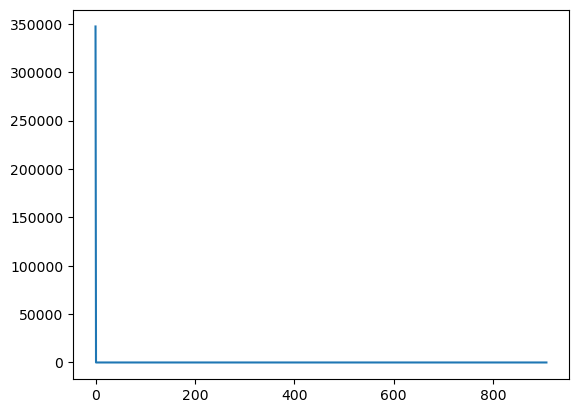

In [ ]:
plt.plot(states_daily_incid[:,1,0]);

In [ ]:
import scipy
states_f = scipy.interpolate.interp1d(
    np.arange(ndays, step=2),
    states[::2, :, :],
    axis=0,
    kind="linear",
    bounds_error=False,  # necessary in some case, for some ti and tf
    fill_value="extrapolate",  # necessary in some case, for some ti and tf
)
states = states_f(np.arange(ndays))

# states_i_f = scipy.interpolate.interp1d(np.arange(ndays, step=2), states_daily_incid[::2, :, :], axis=0, kind="linear")
# states_daily_incid = states_i_f(np.arange(ndays)) / 2
## error is smaller with this bellow, but there should be even smarter ways of doing this TODO
states_daily_incid = np.array(states_daily_incid)
states_daily_incid = states_daily_incid / 2
states_daily_incid[1::2, :, :] = states_daily_incid[:-1:2, :, :]


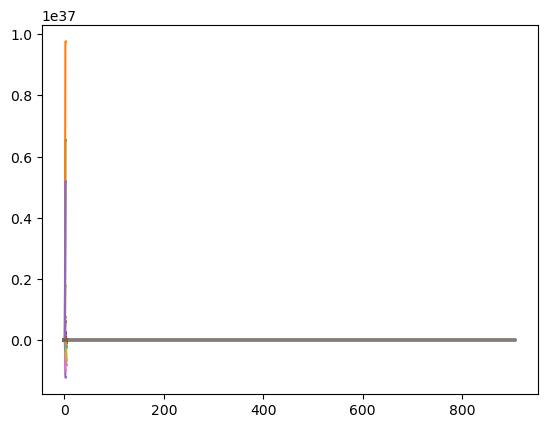